In [61]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import re
import glob

from matplotlib.colors import LogNorm

In [8]:
root_dir = "cmake-build-debug-trilinos"
files = glob.glob("reorder*", root_dir=root_dir)
files

['reordering=amd_size=22_sym_type=general',
 'reordering=amd_size=10_sym_type=near_symmetric',
 'reordering=amd_size=22_sym_type=near_symmetric',
 'reordering=amd_size=22_sym_type=symmetric',
 'reordering=amd_size=10_sym_type=symmetric',
 'reordering=rcm_size=10_sym_type=symmetric',
 'reordering=amd_size=10_sym_type=general',
 'reordering=none_size=46_sym_type=symmetric',
 'reordering=none_size=22_sym_type=general',
 'reordering=none_size=22_sym_type=near_symmetric',
 'reordering=rcm_size=10_sym_type=general',
 'reordering=none_size=46_sym_type=general',
 'reordering=amd_size=46_sym_type=general',
 'reordering=amd_size=46_sym_type=near_symmetric',
 'reordering=none_size=22_sym_type=symmetric',
 'reordering=amd_size=46_sym_type=symmetric',
 'reordering=rcm_size=10_sym_type=near_symmetric',
 'reordering=none_size=10_sym_type=general',
 'reordering=none_size=10_sym_type=near_symmetric',
 'reordering=none_size=10_sym_type=symmetric',
 'reordering=none_size=46_sym_type=near_symmetric',
 're

In [9]:
reordering_re = re.compile(r'\s*Reordering\s*=\s*([\w\d_]+)')
symbolic_type_re = re.compile(r'\s*SymbolicType\s*=\s*([\w\d_]+)')
factorization_re = re.compile(r'\s*Ginkgo Solver.*Factorization:\s(\d+(\.\d+)?)')
apply_re = re.compile(r'\s*Ginkgo Solver.*Apply:\s*(\d+(\.\d+)?)')
size_re = re.compile(r'\s*M\s*=\s*(\d+)')
dim_re = re.compile(r'\s*Dimension\s*=\s*(\d+)')

res = {"reordering": reordering_re,
       "symbolic_type": symbolic_type_re,
       "factorization": factorization_re,
       "apply": apply_re,
       "M": size_re,
       "dim": dim_re}

In [11]:
data = []
for file in files:
    new_data = {}
    with open(f"{root_dir}/{file}", 'r') as f:
        for line in f:
            for name, regex in res.items():
                match = regex.search(line)
                if match:
                    try:
                        new_data[name] = int(match.group(1))
                    except:
                        try:
                            new_data[name] = float(match.group(1))
                        except:
                            new_data[name] = match.group(1)
    data.append(new_data)

In [12]:
df = pd.DataFrame(data)
df["size"] = df.M ** df.dim
df = df.set_index(["reordering", "symbolic_type", "size"])
df

dim   M  factorization     apply
reordering symbolic_type  size                                   
amd        general        10648    3  22       0.635218  0.071414
           near_symmetric 1000     3  10       0.039721  0.044249
                          10648    3  22       0.124523  0.074307
           symmetric      10648    3  22       0.077296  0.072678
                          1000     3  10       0.033177  0.049558
rcm        symmetric      1000     3  10       0.076536  0.009780
amd        general        1000     3  10       0.031638  0.050922
none       symmetric      97336    3  46      10.628500  8.589310
           general        10648    3  22       2.337170  0.198906
           near_symmetric 10648    3  22       0.244036  0.194665
rcm        general        1000     3  10       0.065844  0.016909
none       general        97336    3  46     421.518000  8.139540
amd        general        97336    3  46     101.953000  0.906182
           near_symmetric 97336    3  46       7.621340  0.945458
none       symmetric      10648    3  22       0.154633  0.191705
amd        symmetric      97336    3  46       5.019620  0.906224
rcm        near_symmetric 1000     3  10       0.079191  0.009493
none       general        1000     3  10       0.031092  0.050606
           near_symmetric 1000     3  10       0.045595  0.050522
           symmetric      1000     3  10       0.035440  0.053443
           near_symmetric 97336    3  46      17.256500  8.551460
rcm        general        10648    3  22       1.052070  0.128720
           near_symmetric 10648    3  22       0.207377  0.135854
           symmetric      10648    3  22       0.153539  0.128092
           general        97336    3  46     145.356000  3.957070
           near_symmetric 97336    3  46       7.130140  3.936900
           symmetric      97336    3  46       4.080460  3.825560

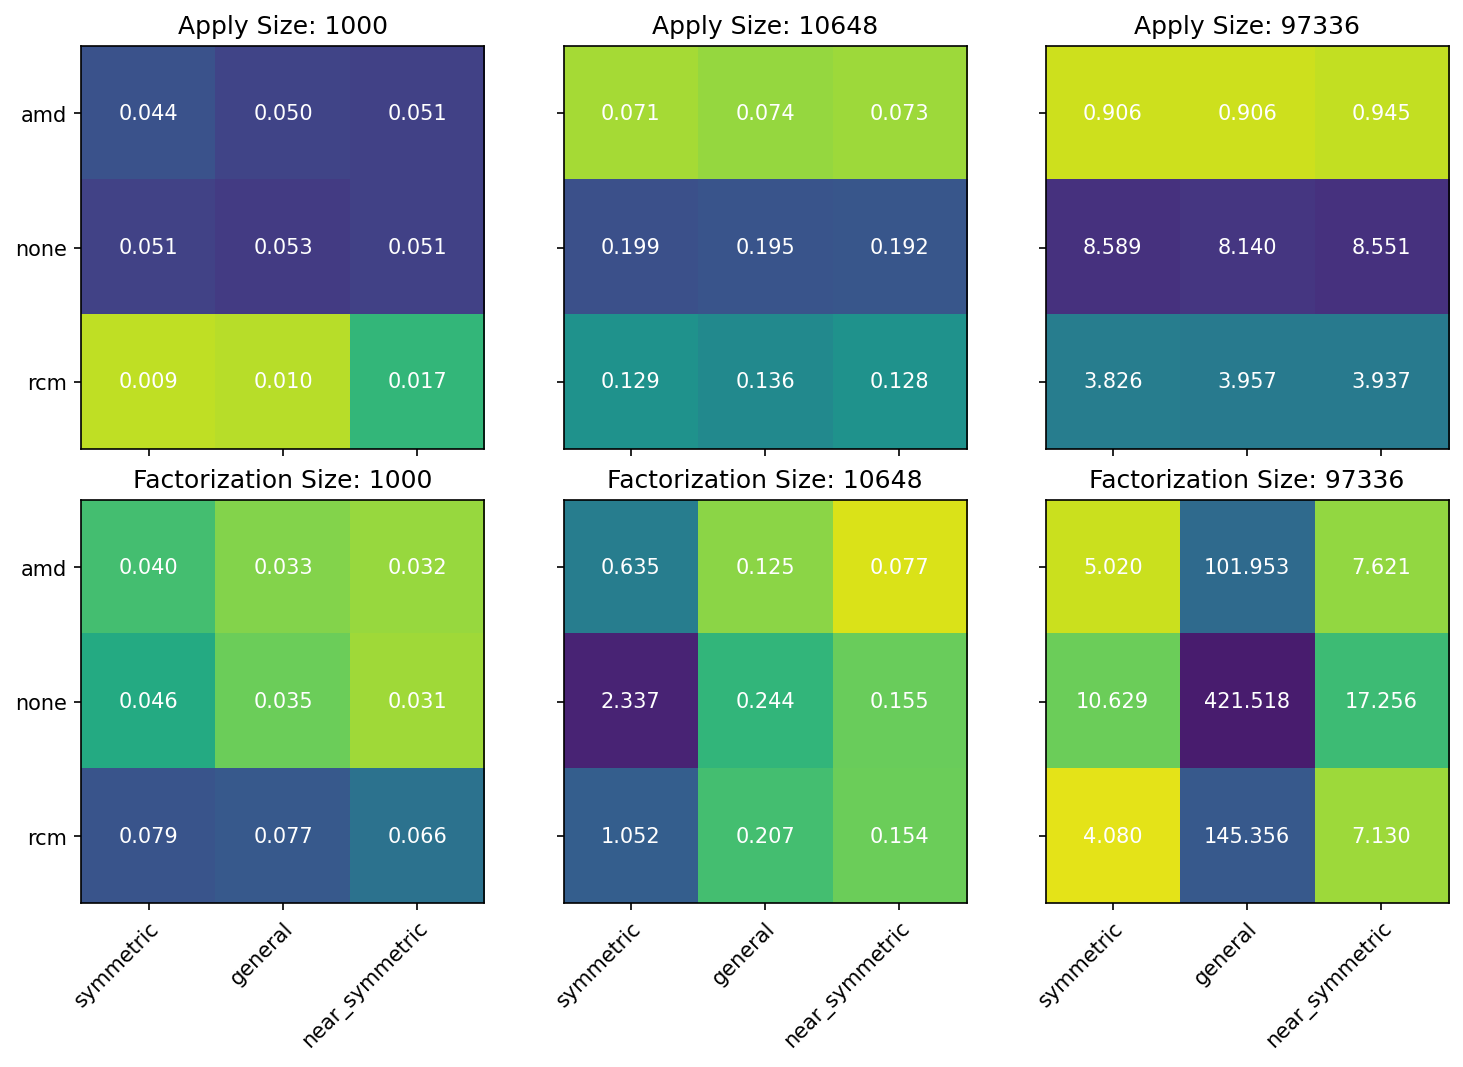

In [86]:
fig, ax = plt.subplots(2, 3, dpi=150, layout="constrained", figsize=(10, 7), sharex=True, sharey=True)

for i, category in enumerate(["apply", "factorization"]):
    _df = df[category].unstack(["size", "symbolic_type"])
    sizes = _df.columns.get_level_values("size").unique()
    for j, s in enumerate(sorted(sizes)):
        __df = _df.xs(s, axis=1, level="size")
        # __df.columns = sorted(__df.columns)

        ax[i, j].imshow(__df.values, cmap="viridis_r", 
                        norm=LogNorm(vmin=__df.values.min() * 0.8, vmax=__df.values.max() * 1.5)
                        )
        
        ax[i, j].set_title(f"{category.capitalize()} Size: {s}")
        
        cols = __df.columns
        ax[i, j].set_xticks(np.arange(len(cols)), labels=cols)
        
        rows = __df.index
        ax[i, j].set_yticks(np.arange(len(rows)), labels=rows)
        
        plt.setp(ax[i, j].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        for ii in range(len(rows)):
            for jj in range(len(cols)):
                ax[i, j].text(jj, ii, f"{__df.iloc[ii, jj]:.3f}", ha="center", va="center", color="white")     
        
plt.show()